In [9]:
# ===== Reduced Order Modeling with NGSolve + pyMOR (POD-Galerkin) =====
from netgen.occ import *

import numpy as np
from ngsolve import *
from ngsolve import Mesh
from netgen.geom2d import unit_square

from pymor.algorithms.pod import pod
from pymor.vectorarrays.numpy import NumpyVectorSpace
import matplotlib.pyplot as plt
from collections import Counter


In [10]:
# ---------- Parameters ----------
L, W, H      = 3.0, 1.0, 1.0
baffle_thk   = 0.05
baffle_len   = 0.70*W
baffle_x     = [0.7, 1.5, 2.3]   # positions of the three baffles
half_model   = False
maxh         = 0.07

# stub parameters
Lin_ext  = 0.4   # inlet stub length
Lout_ext = 0.4   # outlet stub length
stub_frac = 0.5  # fraction of duct cross-section used for stub

# ---------- Main duct ----------
duct = Box(Pnt(0,0,0), Pnt(L, W, H))
duct.faces.name = "walls"

# ---------- Baffles ----------
fluid = duct
for i, x0 in enumerate(baffle_x, 1):
    x0min = x0 - 0.5*baffle_thk
    x0max = x0 + 0.5*baffle_thk
    zmin, zmax = 0, H

    if i == 2:  # middle baffle from TOP wall
        ymin, ymax = W - baffle_len, W
    else:       # side baffles from BOTTOM wall
        ymin, ymax = 0, baffle_len

    plate = Box(Pnt(x0min, ymin, zmin), Pnt(x0max, ymax, zmax))
    plate.faces.name = f"baffle{i}"
    fluid = fluid - plate

# ---------- Inlet stub ----------
stub_ymin = (1-stub_frac)/2 * W
stub_ymax = (1+stub_frac)/2 * W
stub_zmin = (1-stub_frac)/2 * H
stub_zmax = (1+stub_frac)/2 * H

stub_in = Box(Pnt(-Lin_ext, stub_ymin, stub_zmin),
              Pnt(0,        stub_ymax, stub_zmax))
stub_in.faces.name = "walls"           # stub sides are walls
stub_in.faces.Min(X).name = "inlet"    # only far end is inlet

# ---------- Outlet stub ----------
stub_out = Box(Pnt(L, stub_ymin, stub_zmin),
               Pnt(L+Lout_ext, stub_ymax, stub_zmax))
stub_out.faces.name = "walls"          # stub sides are walls
stub_out.faces.Max(X).name = "outlet"  # only far end is outlet

# ---------- Combine duct + stubs ----------
fluid = fluid + stub_in + stub_out

# ---------- Apply half-model cut if desired ----------
if half_model:
    sym_half = HalfSpace(Pnt(0, W/2, 0), Vec(0,1,0))
    fluid = fluid * sym_half

# ---------- Build OCC geometry and mesh ----------
geo = OCCGeometry(fluid)
m = geo.GenerateMesh(maxh=maxh)
mesh = Mesh(m)

print("Mesh elements:", mesh.ne)
print("Boundary names:", mesh.GetBoundaries())

# ---------- Count boundary elements ----------
counter = Counter()
for el in mesh.Elements(BND):
    counter[el.mat] += 1
print("Boundary facet counts:", counter)

# ---------- Visualize boundaries ----------
cf = mesh.BoundaryCF({
    "inlet":   10,
    "outlet":  20,
    "walls":   30,
    "baffle1": 40,
    "baffle2": 50,
    "baffle3": 60
}, default=0)

Draw(mesh)

Mesh elements: 28780
Boundary names: ('walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'baffle1', 'baffle2', 'baffle2', 'baffle2', 'walls', 'walls', 'walls', 'baffle3', 'baffle3', 'baffle3', 'walls', 'baffle1', 'baffle1', 'inlet', 'walls', 'walls', 'walls', 'walls', 'outlet')
Boundary facet counts: Counter({'walls': 6704, 'baffle2': 690, 'baffle1': 662, 'baffle3': 630, 'inlet': 118, 'outlet': 116})


In [11]:
from ngsolve import *
from ngsolve import x, y, z
from ngsolve.webgui import Draw

SetNumThreads(1)

# ------------ parameters ------------
nu_f      = 0.01          # viscosity
U0        = 1.0           # target peak inlet speed
omega0    = 0.3           # under-relaxation
tol       = 1e-4          # Picard stopping criterion
maxit     = 50            # allow more iterations if needed
gamma_gd  = 0.7           # grad-div penalty
use_backflow = True

# ------------ FE spaces ------------
V = VectorH1(mesh, order=1, dirichlet="walls|baffle1|baffle2|baffle3|inlet")
Q = H1(mesh, order=1)
fes = V*Q
(u, p), (v, q) = fes.TnT()

# inlet profile helper
def inlet_cf(U0):
    prof = U0 * (1 - (2*y/W-1)**2) * (1 - (2*z/H-1)**2)
    return CoefficientFunction((prof, 0, 0))

# lifting (velocity only)
def lifting(U0):
    g = GridFunction(fes)
    g.components[0].Set(inlet_cf(U0), BND, definedon=mesh.Boundaries("inlet"))
    return g

# ------------ Stokes warm-start ------------
gS = lifting(U0)  # directly use full U0

aS = BilinearForm(fes, symmetric=True)
aS += nu_f * InnerProduct(Grad(u), Grad(v)) * dx
aS += (-div(v)*p - q*div(u)) * dx
aS += 1e-12*p*q*dx
aS += gamma_gd * div(u)*div(v) * dx

fS = LinearForm(fes)
aS.Assemble(); fS.Assemble()
rhs = fS.vec.CreateVector(); rhs.data = fS.vec - aS.mat*gS.vec
sol = GridFunction(fes)
inv = aS.mat.Inverse(fes.FreeDofs(), inverse="pardiso")
sol.vec.data = gS.vec + inv*rhs

u_vel = GridFunction(V); u_vel.vec.data = sol.components[0].vec
p_prs = GridFunction(Q); p_prs.vec.data = sol.components[1].vec
print("Stokes L2(u) =", float(Integrate(Norm(u_vel), mesh)))

# ------------ Oseen iteration (direct to U0) ------------
n = specialcf.normal(3)
g = lifting(U0)
uk = GridFunction(V); uk.vec.data = u_vel.vec
omega = omega0
last_rel = None

for it in range(1, maxit+1):
    aO = BilinearForm(fes, symmetric=False)
    aO += nu_f * InnerProduct(Grad(u), Grad(v)) * dx
    aO += InnerProduct(Grad(u)*uk, v) * dx
    aO += (-div(v)*p - q*div(u)) * dx
    aO += 1e-12*p*q*dx
    aO += gamma_gd * div(u)*div(v) * dx

    if use_backflow:
        un = InnerProduct(uk, n)
        neg_un = IfPos(-un, -un, 0.0)   # penalize only backflow
        aO += 0.5*neg_un*InnerProduct(u, v) * ds(definedon=mesh.Boundaries("outlet"))

    fO = LinearForm(fes)
    aO.Assemble(); fO.Assemble()
    rhs = fO.vec.CreateVector(); rhs.data = fO.vec - aO.mat*g.vec
    sol = GridFunction(fes)
    inv = aO.mat.Inverse(fes.FreeDofs(), inverse="pardiso")
    sol.vec.data = g.vec + inv*rhs

    du  = GridFunction(V); du.vec.data = sol.components[0].vec - u_vel.vec
    rel = Norm(du.vec) / max(Norm(sol.components[0].vec), 1e-30)
    print(f"  iter {it:2d}: rel = {rel:.3e}, omega={omega:.2f}")

    # under-relaxed update
    u_vel.vec.data = (1-omega)*u_vel.vec + omega*sol.components[0].vec
    p_prs.vec.data = (1-omega)*p_prs.vec + omega*sol.components[1].vec
    uk.vec.data    = u_vel.vec

    if rel < tol:
        print("  converged.")
        break

    if last_rel is not None and rel > 1.25*last_rel and omega > 0.18:
        omega *= 0.7
    last_rel = rel

# ------------ Rescale velocity to U0 ------------
inlet_area = Integrate(1, mesh, BND, definedon=mesh.Boundaries("inlet"))
avg_inlet  = Integrate(Norm(u_vel), mesh, BND, definedon=mesh.Boundaries("inlet")) / inlet_area
scale = U0 / avg_inlet
print(f"\nScaling velocity field by factor {scale}")
u_vel.vec.data *= scale

avg_inlet_new = Integrate(Norm(u_vel), mesh, BND, definedon=mesh.Boundaries("inlet")) / inlet_area
print("new avg |u| on inlet =", avg_inlet_new)

# convection field for scalar problem
b = CoefficientFunction((u_vel[0], u_vel[1], u_vel[2]))
VTKOutput(ma=mesh, coefs=[u_vel], names=["u"], filename="solution_navier", subdivision=2).Do()


Stokes L2(u) = 3.933939983780124
  iter  1: rel = 7.659e-01, omega=0.30
  iter  2: rel = 6.168e-01, omega=0.30
  iter  3: rel = 4.958e-01, omega=0.30
  iter  4: rel = 4.134e-01, omega=0.30
  iter  5: rel = 3.487e-01, omega=0.30
  iter  6: rel = 3.072e-01, omega=0.30
  iter  7: rel = 3.064e-01, omega=0.30
  iter  8: rel = 3.502e-01, omega=0.30
  iter  9: rel = 3.851e-01, omega=0.30
  iter 10: rel = 3.676e-01, omega=0.30
  iter 11: rel = 3.344e-01, omega=0.30
  iter 12: rel = 3.224e-01, omega=0.30
  iter 13: rel = 3.020e-01, omega=0.30
  iter 14: rel = 2.644e-01, omega=0.30
  iter 15: rel = 2.261e-01, omega=0.30
  iter 16: rel = 1.947e-01, omega=0.30
  iter 17: rel = 1.703e-01, omega=0.30
  iter 18: rel = 1.537e-01, omega=0.30
  iter 19: rel = 1.457e-01, omega=0.30
  iter 20: rel = 1.499e-01, omega=0.30
  iter 21: rel = 1.658e-01, omega=0.30
  iter 22: rel = 1.842e-01, omega=0.30
  iter 23: rel = 1.969e-01, omega=0.30
  iter 24: rel = 2.003e-01, omega=0.30
  iter 25: rel = 1.943e-01, ome

'solution_navier'

In [ ]:
# ===============================
# NGSolve + pyMOR ROM pipeline
# ===============================
import numpy as np
from ngsolve import *
from pymor.algorithms.pod import pod
from pymor.vectorarrays.numpy import NumpyVectorSpace

# ------------------------------
# 1) Full-order model setup
# ------------------------------
def setup_full_model(mesh, u_vel, Pe: float,
                     dirichlet_names="walls|inlet|baffle1|baffle2|baffle3",
                     supg_C=1.0):
    """
    Build the stationary advection–diffusion operator with SUPG:
        -nu Δu + b·∇u = 0
    with Dirichlet on 'dirichlet_names' and natural outflow elsewhere.
    Returns a dict with V, A, f, inverse, lifting helper, etc.
    """
    nu = 1.0/Pe

    # FE space (scalar H1)
    V = H1(mesh, order=1, dirichlet=dirichlet_names)
    u, v = V.TnT()

    # convection field b from NS velocity
    b = CoefficientFunction((u_vel[0], u_vel[1], u_vel[2]))
    bnorm = Norm(b) + 1e-12

    # Bilinear form (diffusion + advection + SUPG)
    a = BilinearForm(V, symmetric=False)
    a += nu * InnerProduct(grad(u), grad(v)) * dx
    a += InnerProduct(b, grad(u)) * v * dx

    hK  = specialcf.mesh_size
    tau = supg_C * hK / bnorm                # simple, effective τ ~ h/|b|
    a += tau * (InnerProduct(b,grad(u))) * (InnerProduct(b,grad(v))) * dx

    f = LinearForm(V)                         # zero volume source by default

    # Assemble once
    with TaskManager():
        a.Assemble(); f.Assemble()

    A = a.mat
    invA = A.Inverse(V.FreeDofs(), inverse="pardiso")

    # helper: boundary-lifting GridFunction g from {name: value/None}
    def make_lifting(bc_vals: dict) -> GridFunction:
        """Create GridFunction g with boundary values; use None for Neumann parts."""
        g = GridFunction(V)
        names = list(mesh.GetBoundaries())
        vals  = [0.0 if bc_vals.get(nm, None) is None else float(bc_vals[nm]) for nm in names]
        g.Set(CoefficientFunction(vals), BND)
        return g

    # prototype vector for safe allocations in NumPy <-> NGSolve transfers
    proto = GridFunction(V).vec

    # A_times: apply A to a NumPy vector of size N
    def A_times(vec_np: np.ndarray) -> np.ndarray:
        x = proto.CreateVector(); y = proto.CreateVector()
        if len(vec_np) != len(x.FV().NumPy()):
            raise ValueError(f"Dimension mismatch: got {len(vec_np)} vs FE dim {len(x.FV().NumPy())}")
        x.FV().NumPy()[:] = vec_np
        y.data = A * x
        return y.FV().NumPy()

    # Full-order solve (given Dirichlet values)
    def solve_fom(g1, g2, g3) -> GridFunction:
        bc_vals = {"walls":0.0, "inlet":0.0, "baffle1":g1, "baffle2":g2, "baffle3":g3, "outlet":None}
        g = make_lifting(bc_vals)
        rhs = f.vec.CreateVector(); rhs.data = f.vec - A * g.vec
        uN  = GridFunction(V)
        uN.vec.data = g.vec + invA * rhs
        return uN

    return dict(V=V, A=A, f=f, invA=invA, make_lifting=make_lifting,
                A_times=A_times, solve_fom=solve_fom)


# ------------------------------
# 2) ROM build (POD–Galerkin)
# ------------------------------
def build_rom(fom: dict, g1_fixed: float, g2_train: np.ndarray, g3_fixed: float,
              pod_rtol=1e-3, pod_modes=None):
    """
    Offline: generate snapshots over g2_train, compute POD basis with pyMOR,
    assemble A_rb = V_r^T A V_r.
    Returns dict with Vr, A_rb, and fast solve_rom(g1,g2,g3).
    """
    V      = fom["V"]
    A      = fom["A"]
    A_times= fom["A_times"]
    solve_fom = fom["solve_fom"]
    make_lifting = fom["make_lifting"]

    # --- snapshots
    snaps = []
    for g2 in g2_train:
        u_full = solve_fom(g1_fixed, float(g2), g3_fixed)
        snaps.append(u_full.vec.FV().NumPy().copy())

    N = len(snaps[0])
    space = NumpyVectorSpace(N)
    snap_va = space.make_array(np.vstack(snaps))     # (nsnaps, N)

    # POD
    RB, svals = pod(snap_va, rtol=pod_rtol, modes=pod_modes, l2_err=False)
    r = len(RB)
    print(f"POD kept r={r} modes; snapshots={len(g2_train)}")

    # Basis matrix V_r (N x r)
    Vr = np.column_stack([RB[i].to_numpy().ravel() for i in range(r)])

    # Reduced operator A_rb = V_r^T A V_r
    A_V = np.column_stack([A_times(Vr[:, j]) for j in range(r)])  # (N, r)
    A_rb = Vr.T @ A_V

    # Precompute total POD energy for reporting
    energy = float(np.sum(svals**2))
    def energy_captured(k):  # k <= r
        return float(np.sum(svals[:k]**2) / (energy + 1e-30))

    # Online reduced solve
    from numpy.linalg import solve as dense_solve

    def solve_rom(g1, g2, g3) -> GridFunction:
        # lifting in full space
        g = make_lifting({"walls":0.0, "inlet":0.0, "baffle1":g1, "baffle2":g2, "baffle3":g3, "outlet":None})
        g_np = g.vec.FV().NumPy()
        # rhs_rb = - V_r^T A g
        Ag = A_times(g_np)
        rhs_rb = - Vr.T @ Ag
        # small dense solve
        ur = dense_solve(A_rb, rhs_rb)
        # back to full space
        u_rom_np = g_np + Vr @ ur
        u_rom = GridFunction(V); u_rom.vec.FV().NumPy()[:] = u_rom_np
        return u_rom

    return dict(Vr=Vr, A_rb=A_rb, r=r, svals=svals,
                energy_total=energy, energy_captured=energy_captured,
                solve_rom=solve_rom)


# ------------------------------
# Example usage
# ------------------------------
# 1) Build the full-order operator once
#    (choose Pe and SUPG constant; you can tweak supg_C if needed)
Pe = 400.0
fom = setup_full_model(mesh, u_vel, Pe=Pe, supg_C=1.0)

# 2) Offline ROM: vary g2 over a training grid (keep g1,g3 fixed here)
g1_fix, g3_fix = 1.0, 1.0
g2_train = np.linspace(0.9, 1.1, 14)    # 14 snapshots
rom = build_rom(fom, g1_fixed=g1_fix, g2_train=g2_train, g3_fixed=g3_fix,
                pod_rtol=1e-3, pod_modes=None)

print(f"Energy captured by r={rom['r']}: {rom['energy_captured'](rom['r']):.5f}")

# 3) Compare FOM vs ROM for a test parameter
g1t, g2t, g3t = 1.0, 1.0, 1.0
u_fom = fom["solve_fom"](g1t, g2t, g3t)
u_rom = rom["solve_rom"](g1t, g2t, g3t)

# quick relative A-energy error
A = fom["A"]
diff = GridFunction(fom["V"]); diff.vec.data = u_fom.vec - u_rom.vec
num = InnerProduct(A * diff.vec, diff.vec)
den = max(InnerProduct(A * u_fom.vec, u_fom.vec), 1e-30)
print(f"Relative A-energy error ≈ {float(np.sqrt(num/den)):.3e}")

# 4) Export to ParaView
VTKOutput(ma=mesh, coefs=[u_fom, u_rom], names=["u_fom", "u_rom"],
          filename="rom_compare", subdivision=2).Do()
errL2  = sqrt( Integrate((u_fom - u_rom)**2, mesh) )
normL2 = sqrt( Integrate(u_fom**2,              mesh) )
print("rel L2 =", float(errL2/normL2))
# -- Sanity check: were snapshots homogeneous? --
# pick a training parameter (g2_chk must be one of the g2_train you used)
g2_chk = float(g2_train[len(g2_train)//2])
u_fom_chk = fom["solve_fom"](g1_fix, g2_chk, g3_fix)
g_chk = fom["make_lifting"]({"walls":0.0, "inlet":0.0,
                             "baffle1":g1_fix, "baffle2":g2_chk, "baffle3":g3_fix,
                             "outlet":None})
w_true_np = u_fom_chk.vec.FV().NumPy() - g_chk.vec.FV().NumPy()

# project true homogeneous field to your basis:
Vr = rom["Vr"]
w_proj_coeffs = Vr.T @ w_true_np
w_proj_np = Vr @ w_proj_coeffs

# correlation should be positive and ~1 if snapshots were for w=u-g:
corr = float(np.dot(w_true_np, w_proj_np) /
             (np.linalg.norm(w_true_np)*np.linalg.norm(w_proj_np) + 1e-30))
print("corr(w_true, projection onto Vr) =", corr)


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

POD kept r=2 modes; snapshots=14
Energy captured by r=2: 1.00000
Relative A-energy error ≈ 1.209e+00
rel L2 = 0.42804107178239675
corr(w_true, projection onto Vr) = 0.5061769882248868


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

POD kept r=2 modes; snapshots=32
rel L2 = 6.072e-16
corr(w_true, projection onto Vr) = 0.9999999999999999


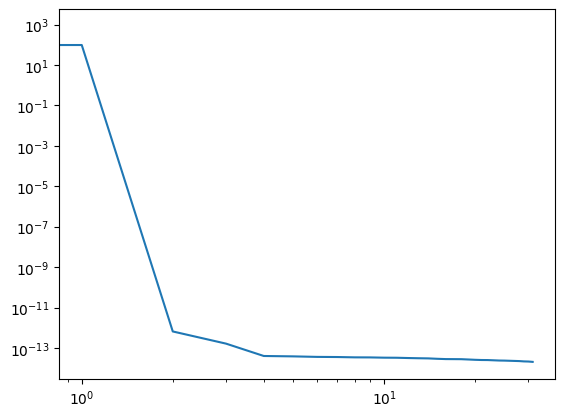

In [45]:
# ---- OFFLINE: build POD basis on homogeneous snapshots w = u_full - g ----
def build_rom_homogeneous(fom, g1_fixed, g2_train, g3_fixed, pod_rtol=1e-6, pod_modes=None):
    import numpy as np
    from pymor.algorithms.pod import pod
    from pymor.vectorarrays.numpy import NumpyVectorSpace

    V            = fom["V"]
    A_times      = fom["A_times"]
    solve_fom    = fom["solve_fom"]
    make_lifting = fom["make_lifting"]

    snaps = []
    with TaskManager():
        for g2 in g2_train:
            g2v = float(g2)
            u_full = solve_fom(g1_fixed, g2v, g3_fixed)
            g      = make_lifting({"walls":0.0, "inlet":0.0,
                                   "baffle1":g1_fixed, "baffle2":g2v, "baffle3":g3_fixed,
                                   "outlet":None})
            w_np = u_full.vec.FV().NumPy() - g.vec.FV().NumPy()
            snaps.append(w_np.copy())

    N = len(snaps[0])
    space   = NumpyVectorSpace(N)
    snap_va = space.make_array(np.vstack(snaps))   # (nsnaps, N)

    # POD on homogeneous snapshots
    RB, svals = pod(snap_va, rtol=pod_rtol, modes=pod_modes, l2_err=False)
    plt.loglog(np.linalg.svd(snaps, compute_uv=False))
    r = len(RB)
    print(f"POD kept r={r} modes; snapshots={len(g2_train)}")

    # Build basis matrix V_r (N x r)
    Vr = np.column_stack([RB[i].to_numpy().ravel() for i in range(r)])

    # Project operator: A_rb = V_r^T A V_r
    A_V  = np.column_stack([A_times(Vr[:, j]) for j in range(r)])
    A_rb = Vr.T @ A_V

    energy = float(np.sum(svals**2))
    def energy_captured(k): return float(np.sum(svals[:k]**2) / (energy + 1e-30))

    # ---- ONLINE reduced solve for the homogeneous unknown w ----
    from numpy.linalg import solve as dsolve
    def solve_rom(g1, g2, g3):
        g = make_lifting({"walls":0.0, "inlet":0.0,
                          "baffle1":g1, "baffle2":g2, "baffle3":g3,
                          "outlet":None})
        g_np = g.vec.FV().NumPy()
        Ag   = A_times(g_np)
        rhs_rb = - Vr.T @ Ag          # A w = -A g
        w_r = dsolve(A_rb, rhs_rb)
        u_rom_np = g_np + Vr @ w_r    # u = g + V_r w_r
        u_rom = GridFunction(V); u_rom.vec.FV().NumPy()[:] = u_rom_np
        return u_rom

    return dict(Vr=Vr, A_rb=A_rb, r=r, svals=svals,
                energy_total=energy, energy_captured=energy_captured,
                solve_rom=solve_rom)

# ---- rebuild ROM (make sure fom is from setup_full_model you are using now) ----
g1_fix, g3_fix = 6.0, 12.0
g2_train = np.linspace(5.0, 13.0, 32)

rom = build_rom_homogeneous(fom, g1_fix, g2_train, g3_fix, pod_rtol=1e-6)

# ---- test at an interior parameter ----
g1t, g2t, g3t = 6.0, 11.0, 12.0
u_fom = fom["solve_fom"](g1t, g2t, g3t)
u_rom = rom["solve_rom"](g1t, g2t, g3t)

# Diagnostics
diff  = u_fom - u_rom
relL2 = float( sqrt(Integrate(diff*diff, mesh)) /
               max(sqrt(Integrate(u_fom*u_fom, mesh)), 1e-30) )
print(f"rel L2 = {relL2:.3e}")

# Correlation check (should be ~+1 now)
g_chk = fom["make_lifting"]({"walls":0.0, "inlet":0.0,
                             "baffle1":g1t, "baffle2":g2t, "baffle3":g3t,
                             "outlet":None})
w_true_np = u_fom.vec.FV().NumPy() - g_chk.vec.FV().NumPy()
w_proj_np = rom["Vr"] @ (rom["Vr"].T @ w_true_np)
corr = float(np.dot(w_true_np, w_proj_np) /
             (np.linalg.norm(w_true_np)*np.linalg.norm(w_proj_np) + 1e-30))
print("corr(w_true, projection onto Vr) =", corr)
